,Borrower_ID,Age,Gender,Employment_Type,Monthly_Income,Num_Dependents,Loan_ID,Loan_Amount,Loan_Tenure,Interest_Rate,...,Collateral_Value,Outstanding_Loan_Amount,Monthly_EMI,Payment_History,Num_Missed_Payments,Days_Past_Due,Recovery_Status,Collection_Attempts,Collection_Method,Legal_Action_Taken
0,BRW_1,59,Male,Salaried,215422,0,LN_1,1445796,60,12.39,...,1.727997e+06,2.914130e+05,4856.88,On-Time,0,0,Partially Recovered,1,Settlement Offer,No
1,BRW_2,49,Female,Salaried,60893,0,LN_2,1044620,12,13.47,...,1.180032e+06,6.652042e+05,55433.68,On-Time,0,0,Fully Recovered,2,Settlement Offer,No
2,BRW_3,35,Male,Salaried,116520,1,LN_3,1923410,72,7.74,...,2.622540e+06,1.031372e+06,14324.61,Delayed,2,124,Fully Recovered,2,Legal Notice,No
3,BRW_4,63,Female,Salaried,140818,2,LN_4,1811663,36,12.23,...,1.145493e+06,2.249739e+05,6249.28,On-Time,1,56,Fully Recovered,2,Calls,No
4,BRW_5,28,Male,Salaried,76272,1,LN_5,88578,48,16.13,...,0.000000e+00,3.918989e+04,816.46,On-Time,1,69,Fully Recovered,0,Debt Collectors,No


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



,Model,Accuracy,F1 Score,ROC AUC
2,Decision Tree,0.960,0.888889,0.956960
3,Gradient Boosting,0.960,0.888889,0.970238
0,Random Forest,0.952,0.869565,0.975962
1,Logistic Regression,0.936,0.818182,0.978022
4,SVM,0.840,0.166667,0.850733


/tmp/ipython-input-2227415060.py:169: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




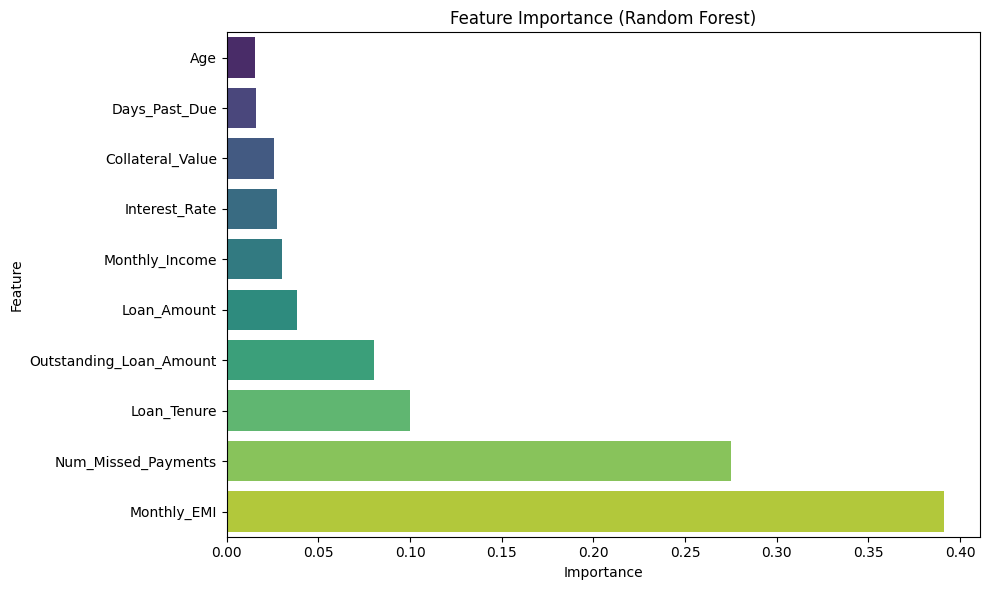

In [10]:
# =============================
# Loan Recovery Analysis Project
# =============================
# Author: Abhivyakti Jha
# Description: Loan recovery EDA, clustering, and ML models for risk prediction.

# ------------------------------
# 1. Import Libraries
# ------------------------------
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from IPython.display import display

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ------------------------------
# 2. Load Dataset
# ------------------------------
loan_data = pd.read_csv("/content/loan-recovery (2).csv")
display(loan_data.head())

# ------------------------------
# 3. Exploratory Data Analysis
# ------------------------------
figures = []

# Loan Amount Distribution with KDE + Scatter
fig1 = px.histogram(
    loan_data, x="Loan_Amount", nbins=30, marginal="violin", opacity=0.6,
    title="Loan Amount Distribution WRT Monthly Income",
    labels={"Loan_Amount": "Loan Amount ($)", "Monthly Income": "Monthly Income ($)"},
    color_discrete_sequence=["royalblue"]
)
x_vals = np.linspace(loan_data["Loan_Amount"].min(), loan_data["Loan_Amount"].max(), 200)
kde = gaussian_kde(loan_data["Loan_Amount"])
y_vals = kde(x_vals)
fig1.add_trace(go.Scatter(x=x_vals, y=y_vals, mode="lines", name="Density Curve",
                         line=dict(color="red", width=2)))
scatter = px.scatter(
    loan_data, x="Loan_Amount", y="Monthly_Income", color="Loan_Amount",
    color_continuous_scale="Viridis", size=loan_data["Loan_Amount"],
    hover_name=loan_data.index
)
for trace in scatter.data:
    fig1.add_trace(trace)
fig1.show()
figures.append(("loan_amount_distribution", fig1))

# Payment History vs Recovery
fig2 = px.histogram(
    loan_data, x="Payment_History", color="Recovery_Status", barmode="group",
    title="Payment History vs Recovery",
    color_discrete_map={"Recovered": "green", "Not Recovered": "red"}
)
fig2.show()
figures.append(("payment_history", fig2))

# Missed Payments vs Recovery
fig3 = px.box(
    loan_data, x="Recovery_Status", y="Num_Missed_Payments", points="all",
    title="Missed Payments vs Recovery",
    color="Recovery_Status",
    color_discrete_map={"Recovered": "green", "Not Recovered": "red"}
)
fig3.show()
figures.append(("missed_payments", fig3))

# Loan vs Income Recovery
fig4 = px.scatter(
    loan_data, x="Loan_Amount", y="Monthly_Income", color="Recovery_Status",
    title="Loan vs Income vs Recovery",
    color_discrete_map={"Recovered": "green", "Not Recovered": "red"}
)
fig4.add_annotation(
    x=max(loan_data["Loan_Amount"]), y=max(loan_data["Monthly_Income"]),
    text="Higher loans may still recover if income is high",
    showarrow=True, arrowhead=2, font=dict(size=12, color="red")
)
fig4.show()
figures.append(("loan_income_recovery", fig4))

# ------------------------------
# 4. Borrower Clustering (KMeans)
# ------------------------------
features = ["Age","Monthly_Income","Loan_Tenure","Interest_Rate","Collateral_Value",
            "Monthly_EMI","Num_Missed_Payments","Days_Past_Due"]

scaler = StandardScaler()
loan_data_scaled = scaler.fit_transform(loan_data[features])

kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
loan_data["Borrower_segment"] = kmeans.fit_predict(loan_data_scaled)
loan_data["Segment_name"] = loan_data["Borrower_segment"].map({
    0: "Moderate income, high loan burden",
    1: "High income, low default risk",
    2: "Moderate income, medium risk",
    3: "High loan, higher default risk"
})

fig5 = px.scatter(
    loan_data, x="Monthly_Income", y="Loan_Amount",
    color=loan_data["Borrower_segment"].astype(str),
    size="Loan_Amount", title="Borrower Segments (KMeans)",
    color_discrete_sequence=px.colors.qualitative.Vivid
)
fig5.show()
figures.append(("borrower_segments", fig5))

# ------------------------------
# 5. Risk Prediction Models
# ------------------------------
loan_data["High_Risk_Flag"] = loan_data["Segment_name"].apply(
    lambda x: 1 if x in ["High loan, higher default risk", "Moderate income, high loan burden"] else 0
)

X = loan_data[["Age","Monthly_Income","Loan_Amount","Loan_Tenure","Interest_Rate",
               "Collateral_Value","Outstanding_Loan_Amount","Monthly_EMI",
               "Num_Missed_Payments","Days_Past_Due"]]
y = loan_data["High_Risk_Flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    results.append({"Model": name, "Accuracy": acc, "F1 Score": f1, "ROC AUC": auc})
    logging.info(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}, AUC={auc}")

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
display(results_df)

# ------------------------------
# 6. Feature Importance (Random Forest)
# ------------------------------
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances}).sort_values(by="Importance")

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

# ------------------------------
# 7. Save Figures (Static + Interactive)
# ------------------------------
for filename, fig in figures:
    fig.write_html(f"{filename}.html")   # Interactive version

